In [18]:
# Imports
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [19]:
loc = '/home/sh16450/code/'
# drifting snow mass flux (3D)
# default is g/kg, therefore divide by 1000
LQS = xr.open_dataset(loc + 'daily-LQS-MAR_ERA5-2007-2016.nc')['LQS']/1000
# cloud optical depth (COD)
COD = xr.open_dataset(loc + 'daily-COD-MAR_ERA5-2007-2016.nc')

In [39]:
# Create the filter thresholds for clear-sky days based on cloud optical depth
filter_COD = 0.7
# sum adds +1 for every instance where clear-sky detected
# divided by the total length of the time axis gives frequency of clear skies
frequency_clear = (COD['COD'] < filter_COD).sum(dim='TIME') / np.shape(COD['COD'])[0]
time_clear = (COD['COD'] < filter_COD)
# Create the filter threshold for blowing snow conditions
# 10^(-7) kg/kg*day is based on Gerber et al. (2023), Sec 2.1
filter_qs = 10**(-5)
# Where is blowing snow detected?
blowing_snow = LQS.where(LQS >= filter_qs)
# Vertical sum of daily detected blowing snow instances
bs_vert_total = (LQS > filter_qs).sum(dim='ATMLAY') # total sum of vertical detections of BS



In [44]:
time_clear


<xarray.DataArray 'COD' (TIME: 3653, Y: 148, X: 176)>
array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True, False, False, ...,  True,  True,  True],
        [ True, False, False, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ..., False, False,  True],
        [ True,  True,  True, ..., False, False,  True],
        ...,
        [ True, False, False, ...,  True,  True,  True],
        [ True, False, False, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ..., False,  True,  True],
        ...,
...
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True, False, False, ..., False,  True,  True],
        [ True, False, False, ..., False, False,  True],
        ...,
        [ True,  True,  True, ..., False, False,  True],
        [ True,  True,  True, ..., False, False,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True, False, ..., False,  True,  True],
        [ True, False, False, ..., False, False,  True],
        ...,
        [ True,  True,  True, ..., False, False,  True],
        [ True,  True,  True, ..., False, False,  True],
        [ True,  True,  True, ...,  True,  True,  True]]])
Coordinates:
  * TIME     (TIME) datetime64[ns] 2007-01-01T12:00:00 ... 2016-12-31T12:00:00
  * X        (X) float32 -3.01e+03 -2.975e+03 -2.94e+03 ... 3.08e+03 3.115e+03
  * Y        (Y) float32 -2.555e+03 -2.52e+03 -2.485e+03 ... 2.555e+03 2.59e+03

1. Remove all cloudy days from LQS
2. Apply BS threshold to LQS
3. Monthly sum of BS occurences
    - Sum along vertical axis (*ATMLAY*)
    - Resample or groupby

In [45]:
# LQS but cloudy days removed
LQS_no_clouds = LQS.where(time_clear == True) 
# This yields 0 when false and 1 when BS is above threshold
LQS_bs_clear = (LQS_no_clouds > filter_qs) # LQS above detectable blowing snow threshold
# This keeps the actual LQS values when clear and BS detected
LQS_clear_and_bs = LQS.where((time_clear == True)&(LQS > filter_qs)) 
# sum of vertical layers that detected blowing snow
total_vert_bs = LQS_bs_clear.sum(dim='ATMLAY')

# True or false if at least one layer on a given day had blowing snow
vert_snow_detected = total_vert_bs > 0



In [48]:
# Sum per month of cloud-free BS occurences
LQS_bs_clear_sum = LQS_bs_clear.resample(TIME='MS').sum()
# This version detects blowing snow if at least one ATMLAY has detected BS
LQS_bs_clear_sum_alt = vert_snow_detected.resample(TIME='MS').sum()



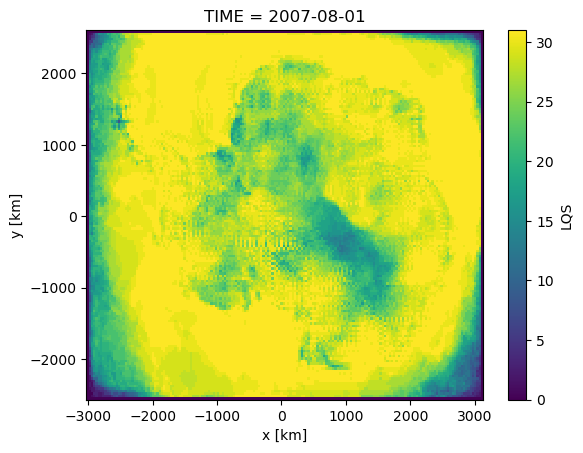

In [47]:
LQS_bs_clear_sum_alt[7,:,:].plot()

In [ ]:
fig,axs = plt.subplots(nrows=1, ncols=2)
LQS_bs_clear_sum.mean(dim=['Y', 'X']).plot(ax=axs[0])


In [21]:
days_in_month = LQS_bs_clear_sum.TIME.dt.daysinmonth # AMAZING :-D Gives days in each month for the frequency analysis
LQS_bs_clear_sum/days_in_month

<xarray.DataArray 'LQS' (TIME: 120, ATMLAY: 10, Y: 148, X: 176)>
array([[[[ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  6,  7, ..., 13, 11,  0],
         [ 0,  8,  9, ..., 15, 13,  0],
         ...,
         [ 0, 18, 23, ..., 24, 26,  0],
         [ 0, 15, 20, ..., 26, 25,  0],
         [ 0,  0,  0, ...,  0,  0,  0]],

        [[ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  3,  4, ...,  9,  8,  0],
         [ 0,  4,  5, ..., 10, 10,  0],
         ...,
         [ 0, 13, 18, ..., 24, 22,  0],
         [ 0,  9, 15, ..., 22, 21,  0],
         [ 0,  0,  0, ...,  0,  0,  0]],

        [[ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  2,  0, ...,  5,  6,  0],
         [ 0,  1,  3, ...,  7,  5,  0],
         ...,
...
         ...,
         [ 0, 14, 26, ..., 16, 13,  0],
         [ 0,  9, 15, ..., 12, 11,  0],
         [ 0,  0,  0, ...,  0,  0,  0]],

        [[ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  2,  3, ...,  5,  3,  0],
         [ 0,  3,  6, ..., 11,  5,  0],
         ...,
         [ 0, 15, 28, ..., 17, 13,  0],
         [ 0, 10, 17, ..., 15, 10,  0],
         [ 0,  0,  0, ...,  0,  0,  0]],

        [[ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  2,  3, ...,  5,  1,  0],
         [ 0,  2,  4, ...,  7,  4,  0],
         ...,
         [ 0, 16, 27, ..., 16, 14,  0],
         [ 0, 10, 12, ..., 15,  9,  0],
         [ 0,  0,  0, ...,  0,  0,  0]]]])
Coordinates:
  * X        (X) float32 -3.01e+03 -2.975e+03 -2.94e+03 ... 3.08e+03 3.115e+03
  * Y        (Y) float32 -2.555e+03 -2.52e+03 -2.485e+03 ... 2.555e+03 2.59e+03
  * ATMLAY   (ATMLAY) float32 0.9541 0.973 0.9844 ... 0.9989 0.9995 0.9997
  * TIME     (TIME) datetime64[ns] 2007-01-01 2007-02-01 ... 2016-12-01